In [1]:
using Distributed, Plotly, DataFrames, Plots, PyPlot
plotly()
addprocs(7)

@everywhere using StatsBase, Distributions, SharedArrays
@everywhere include("episiming.jl");

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-3557113601817895679\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-17022719751320727860\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-3557113601817895679\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

┌ Info: For saving to png with the Plotly backend ORCA has to be installed.
└ @ Plots /home/rodrigo/.julia/packages/Plots/ninUP/src/backends.jl:375


In [2]:
@everywhere function powerDecay(a::Number, b::Number, x)
    y = rowWiseNorm(x)
    return 1.0 ./ (1.0 .+ (y ./ a) .^ b)
end

@everywhere  fKernel(x) = powerDecay(1., 1.5, x)

In [3]:
@everywhere censoResidencial = [.21, .26, .20, .17, .08, .04, .02, 0.02];

In [4]:
@everywhere geradorCenso(x) = geraResidencias(x, censoResidencial)
@everywhere geradorDensidade(k) = (x) -> geraResidencias(x, k)

# Rio de Janeiro

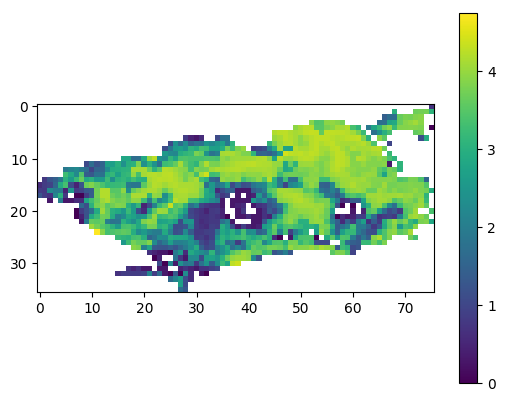

In [5]:
file = open("landScan.bin", "r")
data = reinterpret(Int64, read(file))
close(file)

dadosRJ = reshape(data, (36, 76));
dadosRJ[dadosRJ .< 0] .= 0;

PyPlot.imshow(log10.(dadosRJ))
PyPlot.colorbar();

In [6]:
dadosAjustados = floor.(Int, dadosRJ ./ 1);

In [7]:
αᵣ = 0.8
βᵢ = 0.30
βₐ = 0.05

@everywhere geradorθᵢ() = (self::Particula, x) -> βᵢ / self.n ^ αᵣ
@everywhere geradorθₐ() = (self::Particula, x) -> βₐ / self.n ^ αᵣ

In [8]:
@time populacao = geraRedeResidencial(dadosAjustados, geradorCenso, geradorθᵢ, geradorθₐ, 10000, fKernel, writeDisk=true);

3742.713882 seconds (409.46 M allocations: 1.558 TiB, 43.54% gc time)


In [17]:
@everywhere function leDistancia(populacao::Populacao, diaContagio, cargaViral, t, suscetiveis, infectados)
    """
        Calcula soma das distancias entre os infectados e os suscetiveis, 
        tomando a distancia media entre pessoas de bairros diferentes e lendo a matriz de distancias
        para pessoas do mesmo bairro.
    """
    aux = zeros(populacao.n)
    infectadosBairros = [sum(populacao.ρ[i.pessoas[infectados[i.pessoas]]] .* cargaViral(diaContagio[i.pessoas[infectados[i.pessoas]]], t)) for i in populacao.bairros]
    for i in 1:length(populacao.bairros)
        bairro = populacao.bairros[i]
        suscetiveisBairro = bairro.pessoas[suscetiveis[bairro.pessoas]]
        infectadosBairro = bairro.pessoas[infectados[bairro.pessoas]]
        contatosBairro = abreEps(populacao.rodada, i)[suscetiveis[bairro.pessoas], infectados[bairro.pessoas]]
        contatosBairro .*= (populacao.ρ[infectadosBairro] .* cargaViral(diaContagio[infectadosBairro], t))'
        aux[suscetiveisBairro] .+= sum(infectadosBairros .* bairro.distancias)
        aux[suscetiveisBairro] .+= sum(contatosBairro, dims=2)[:, 1]
    end
    return aux[suscetiveis]
end

@everywhere leDistancia(populacao::Populacao) = leDistancia(populacao, zeros(populacao.n), (x, t) -> 1, 1, ones(Bool, populacao.n), ones(Bool, populacao.n))

In [18]:
@time dist = leDistancia(populacao);
@eval @everywhere dist=$dist

490.801587 seconds (654.94 k allocations: 77.848 GiB, 1.00% gc time)


In [19]:
# ρForma = 0.2 # shape factor of gamma distribution
# ρEscala = 5 # scale (mean value = scale * shape)
# ρPop = rand(Gamma(ρForma, ρEscala), nPessoas)

βᵤᵢ = 0.06
βᵤₐ = 0.006
γ = 0.1;

parametros = SEAIR(fKernel, γ, 1/3, 4/6, (t) -> βᵤᵢ ./ dist, (t) -> βᵤₐ ./ dist, (a, t) -> ones(length(a)));

# Sem paralelismo

In [20]:
nSim = nworkers()
tempos =  Array(1:2);

In [23]:
@time evolucaoMista(populacao, tempos, parametros);

329.589590 seconds (156.77 M allocations: 85.070 GiB, 4.27% gc time)


# Paralelismo simples das simulações

In [24]:
@time a = @evolucaoParalela(populacao, tempos, parametros, nSim);

Base.IOError: IOError: write: not enough memory (ENOMEM)

# Outras tentativas

In [19]:
@time a = @evolucaoParalela(populacao, tempos, parametros, nSim, S, E, A, I, R, transicoes);

159.207262 seconds (233.38 k allocations: 11.764 MiB)


In [105]:
a

6-element Array{Tuple{Array{Float64,1},Array{Float64,1},Array{Float64,1},Array{Float64,1},Array{Float64,1},Array{Int64,2}},1}:
 ([6.847853e6, 6.847853e6], [0.0, 6677.0], [0.0, 2250.0], [10000.0, 1073.0], [0.0, 0.0], [-1 -1 -1; -1 -1 -1; … ; -1 -1 -1; -1 -1 -1])
 ([6.847853e6, 6.847853e6], [0.0, 6632.0], [0.0, 2285.0], [10000.0, 1083.0], [0.0, 0.0], [-1 -1 -1; -1 -1 -1; … ; -1 -1 -1; -1 -1 -1])
 ([6.847853e6, 6.847853e6], [0.0, 6629.0], [0.0, 2257.0], [10000.0, 1114.0], [0.0, 0.0], [-1 -1 -1; -1 -1 -1; … ; -1 -1 -1; -1 -1 -1])
 ([6.847853e6, 6.847853e6], [0.0, 6708.0], [0.0, 2194.0], [10000.0, 1098.0], [0.0, 0.0], [-1 -1 -1; -1 -1 -1; … ; -1 -1 -1; -1 -1 -1])
 ([6.847853e6, 6.847853e6], [0.0, 6752.0], [0.0, 2182.0], [10000.0, 1066.0], [0.0, 0.0], [-1 -1 -1; -1 -1 -1; … ; -1 -1 -1; -1 -1 -1])
 ([6.847853e6, 6.847853e6], [0.0, 6678.0], [0.0, 2233.0], [10000.0, 1089.0], [0.0, 0.0], [-1 -1 -1; -1 -1 -1; … ; -1 -1 -1; -1 -1 -1])

In [22]:
@btime a = evolucaoMista(populacao, Array(1:2), parametros);

  3.825 s (58399602 allocations: 2.57 GiB)


In [14]:
Plots.plot((mean(S, dims=1)[1, :]), label = "Suscetíveis")
Plots.plot!((mean(I, dims=1)[1, :]), label = "Infectados")
Plots.plot!((mean(R, dims=1)[1, :]), label = "Recuperados")

<!DOCTYPE html>
 
 
 Plots.jl

In [ ]:
GC.gc()